In [1]:
import sys
import os

# Add Codes/src to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src')))

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

from plot_utils import plot_comparison_boxplots
from train_utils import BatteryTrainerBase, BatterySeqDataset, build_lstm_sequences, pad_collate_fn


In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
df = pd.read_pickle('../../../Datasets/processed/merged_interp_flat.pkl')
df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,dqdt_min,dqdt_max,dqdt_mean,dqdt_std,dvdt_min,...,i_interp_991,i_interp_992,i_interp_993,i_interp_994,i_interp_995,i_interp_996,i_interp_997,i_interp_998,i_interp_999,source
0,B0005,2.0,1,1.856487,0.928244,-1.332504e-07,0.002876,0.000528,0.000255,-0.006229,...,0.004819,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,nasa
1,B0005,2.0,3,1.846327,0.923164,-4.510385e-07,0.002894,0.000527,0.000257,-0.006004,...,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,nasa
2,B0005,2.0,5,1.835349,0.917675,-1.163391e-07,0.002333,0.000520,0.000227,-0.005953,...,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,nasa
3,B0005,2.0,7,1.835263,0.917631,-2.062661e-07,0.002885,0.000530,0.000255,-0.005907,...,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,nasa
4,B0005,2.0,9,1.834646,0.917323,-5.353266e-07,0.002896,0.000530,0.000256,-0.005923,...,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,nasa


In [5]:
# ============================
# LSTM Model
# ============================
class BatteryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=1, dropout=0.0, bidirectional=False, output_dim=1):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, 
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return torch.sigmoid(out)  # or remove sigmoid if not using minmax

In [ ]:
class BatteryTrainer(BatteryTrainerBase):
    def train(self, train_df, val_df, feature_cols=None, epochs=20, **model_kwargs):

        target_col = self.target_cols[0]  # should be "soh"
        train_df = train_df.copy()
        val_df = val_df.copy()

        ###
        # Min-max normalize target using train_df only (to avoid leakage)
        ###
        soh_min = train_df["soh"].min()
        soh_max = train_df["soh"].max()

        train_df[target_col] = (train_df["soh"] - soh_min) / (soh_max - soh_min)
        val_df[target_col] = (val_df["soh"] - soh_min) / (soh_max - soh_min)

        ###
        # Build full-sequence dataset (per cell)
        ###
        X_train_seq, y_train_seq = build_lstm_sequences(train_df, feature_cols, target_col)
        X_val_seq, y_val_seq = build_lstm_sequences(val_df, feature_cols, target_col)

        train_loader = DataLoader(
            BatterySeqDataset(X_train_seq, y_train_seq),
            batch_size=model_kwargs.get("batch_size", 1),
            shuffle=True,
            collate_fn=pad_collate_fn
        )

        val_loader = DataLoader(
            BatterySeqDataset(X_val_seq, y_val_seq),
            batch_size=model_kwargs.get("batch_size", 1),
            collate_fn=pad_collate_fn
        )

        ###
        # Initialize model
        ###
        model = BatteryLSTM(
            input_dim=len(feature_cols),
            output_dim=1,
            hidden_dim=model_kwargs.get("hidden_dim", 128),
            num_layers=model_kwargs.get("num_layers", 2),
            dropout=model_kwargs.get("dropout", 0.0),
            bidirectional=model_kwargs.get("bidirectional", False),
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=model_kwargs.get("lr", 1e-3))
        criterion = torch.nn.MSELoss()

        ###
        # Training loop
        ###
        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                pred = model(xb).squeeze(-1)
                loss = criterion(pred, yb[:, -1])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        ###
        # Evaluation
        ###
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb).squeeze(-1)
                val_preds.append(pred.numpy())
                val_targets.append(yb[:, -1].numpy())

        val_targets = np.concatenate(val_targets)
        val_preds = np.concatenate(val_preds)

        ###
        # Denormalize target back to real SoH scale
        ###
        val_targets_real = val_targets * (soh_max - soh_min) + soh_min
        val_preds_real = val_preds * (soh_max - soh_min) + soh_min

        ###
        # Print metrics in real-world SoH
        ###
        print(f"LSTM Val MSE={mean_squared_error(val_targets_real, val_preds_real):.4f}, "
            f"MAE={mean_absolute_error(val_targets_real, val_preds_real):.4f}, "
            f"R²={r2_score(val_targets_real, val_preds_real):.4f}")

        return model, val_targets_real, val_preds_real



    def optuna_objective(self, trial):
        ###
        # UBAH DISINI SESUAI MODEL MASING MASING
        ###
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_int("num_layers", 2, 3)
        dropout = trial.suggest_float("dropout", 0.0, 0.5)
        bidirectional = trial.suggest_categorical("bidirectional", [False, True])
        lr = trial.suggest_categorical("lr", [1e-3, 1e-4])   
        batch_size = trial.suggest_categorical("batch_size", [1, 4, 8])

        result = self.cross_validate(
            lr=lr,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_size=batch_size
            )
          # for robust
        std_mse = np.std(result.mse)
        score = result.avg_mse + 0.8 * std_mse # we can tune the weight

        return score


In [7]:
trainer = BatteryTrainer(df, target_cols=['soh'])

In [8]:
trainer.cross_validate()


=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0134, MAE=0.0857, R²=0.3301
  MSE: 0.0134, MAE: 0.0857, R²: 0.3301

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0082, MAE=0.0714, R²=0.5150
  MSE: 0.0082, MAE: 0.0714, R²: 0.5150

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0089, MAE=0.0713, R²=0.4246
  MSE: 0.0089, MAE: 0.0713, R²: 0.4246

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0132, MAE=0.0844, R²=0.3364
  MSE: 0.0132, MAE: 0.0844, R²: 0.3364

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0118, MAE=0.0781, R²=0.4119
  MSE: 0.0118, MAE: 0.0781, R²: 0.4119

=== Avera

CVResult(mse=[0.013385836, 0.008243132, 0.008931589, 0.013237023, 0.011750855], mae=[0.0857435, 0.07144943, 0.07131056, 0.08438177, 0.07809249], r2=[0.33012914657592773, 0.5150055885314941, 0.42455345392227173, 0.33641427755355835, 0.4119275212287903], avg_mse=0.011109686, avg_mae=0.07819555, avg_r2=0.40360599756240845)

In [9]:
study = trainer.run_optuna_tuning()

[I 2025-04-17 13:05:54,015] A new study created in memory with name: no-name-2c31f18c-f04c-4417-aec2-1de6747d7646



=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0009, MAE=0.0115, R²=0.9812
  MSE: 0.0009, MAE: 0.0115, R²: 0.9812

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0032, MAE=0.0215, R²=0.9232
  MSE: 0.0032, MAE: 0.0215, R²: 0.9232

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0025, MAE=0.0184, R²=0.9593
  MSE: 0.0025, MAE: 0.0184, R²: 0.9593

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0016, MAE=0.0156, R²=0.9672
  MSE: 0.0016, MAE: 0.0156, R²: 0.9672

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


[I 2025-04-17 13:08:21,230] Trial 0 finished with value: 0.0017144599696621299 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.07800932022121826, 'bidirectional': False, 'lr': 0.001, 'batch_size': 8}. Best is trial 0 with value: 0.0017144599696621299.


LSTM Val MSE=0.0004, MAE=0.0091, R²=0.9916
  MSE: 0.0004, MAE: 0.0091, R²: 0.9916

=== Average CV Performance ===
Avg MSE: 0.0017
Avg MAE: 0.0152
Avg R² : 0.9645

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0025, MAE=0.0342, R²=0.9463
  MSE: 0.0025, MAE: 0.0342, R²: 0.9463

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0043, MAE=0.0392, R²=0.8953
  MSE: 0.0043, MAE: 0.0392, R²: 0.8953

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0056, MAE=0.0414, R²=0.9091
  MSE: 0.0056, MAE: 0.0414, R²: 0.9091

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0072, MAE=0.0461, R²=0.8545
  MSE: 0.0072, MAE: 0.0461, R²: 0.8545

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:09:42,382] Trial 1 finished with value: 0.004287414718419313 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.15212112147976886, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 8}. Best is trial 0 with value: 0.0017144599696621299.


LSTM Val MSE=0.0018, MAE=0.0281, R²=0.9612
  MSE: 0.0018, MAE: 0.0281, R²: 0.9612

=== Average CV Performance ===
Avg MSE: 0.0043
Avg MAE: 0.0378
Avg R² : 0.9133

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0026, MAE=0.0217, R²=0.9667
  MSE: 0.0026, MAE: 0.0217, R²: 0.9667

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0018, MAE=0.0184, R²=0.9730
  MSE: 0.0018, MAE: 0.0184, R²: 0.9730

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0029, MAE=0.0252, R²=0.9642
  MSE: 0.0029, MAE: 0.0252, R²: 0.9642

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0023, MAE=0.0214, R²=0.9665
  MSE: 0.0023, MAE: 0.0214, R²: 0.9665

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:15:59,413] Trial 2 finished with value: 0.0027184258215129375 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.29620728443102123, 'bidirectional': True, 'lr': 0.001, 'batch_size': 4}. Best is trial 0 with value: 0.0017144599696621299.


LSTM Val MSE=0.0040, MAE=0.0319, R²=0.9481
  MSE: 0.0040, MAE: 0.0319, R²: 0.9481

=== Average CV Performance ===
Avg MSE: 0.0027
Avg MAE: 0.0237
Avg R² : 0.9637

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0122, MAE=0.0798, R²=0.3895
  MSE: 0.0122, MAE: 0.0798, R²: 0.3895

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0055, MAE=0.0597, R²=0.6739
  MSE: 0.0055, MAE: 0.0597, R²: 0.6739

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0106, MAE=0.0679, R²=0.3149
  MSE: 0.0106, MAE: 0.0679, R²: 0.3149

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0084, MAE=0.0697, R²=0.5767
  MSE: 0.0084, MAE: 0.0697, R²: 0.5767

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:24:15,549] Trial 3 finished with value: 0.009654474444687366 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.06101911742238941, 'bidirectional': False, 'lr': 0.001, 'batch_size': 1}. Best is trial 0 with value: 0.0017144599696621299.


LSTM Val MSE=0.0115, MAE=0.0825, R²=0.4268
  MSE: 0.0115, MAE: 0.0825, R²: 0.4268

=== Average CV Performance ===
Avg MSE: 0.0097
Avg MAE: 0.0719
Avg R² : 0.4764

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0008, MAE=0.0101, R²=0.9819
  MSE: 0.0008, MAE: 0.0101, R²: 0.9819

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0011, MAE=0.0143, R²=0.9726
  MSE: 0.0011, MAE: 0.0143, R²: 0.9726

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0020, MAE=0.0193, R²=0.9679
  MSE: 0.0020, MAE: 0.0193, R²: 0.9679

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0016, MAE=0.0165, R²=0.9668
  MSE: 0.0016, MAE: 0.0165, R²: 0.9668

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:28:26,954] Trial 4 finished with value: 0.0012186996173113585 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.46974947078209456, 'bidirectional': False, 'lr': 0.001, 'batch_size': 8}. Best is trial 4 with value: 0.0012186996173113585.


LSTM Val MSE=0.0005, MAE=0.0084, R²=0.9893
  MSE: 0.0005, MAE: 0.0084, R²: 0.9893

=== Average CV Performance ===
Avg MSE: 0.0012
Avg MAE: 0.0137
Avg R² : 0.9757

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0112, MAE=0.0706, R²=0.4409
  MSE: 0.0112, MAE: 0.0706, R²: 0.4409

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0116, MAE=0.0869, R²=0.3149
  MSE: 0.0116, MAE: 0.0869, R²: 0.3149

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0114, MAE=0.0831, R²=0.2662
  MSE: 0.0114, MAE: 0.0831, R²: 0.2662

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0101, MAE=0.0756, R²=0.4935
  MSE: 0.0101, MAE: 0.0756, R²: 0.4935

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:36:06,267] Trial 5 finished with value: 0.010760245844721794 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.14046725484369038, 'bidirectional': False, 'lr': 0.001, 'batch_size': 1}. Best is trial 4 with value: 0.0012186996173113585.


LSTM Val MSE=0.0095, MAE=0.0741, R²=0.5249
  MSE: 0.0095, MAE: 0.0741, R²: 0.5249

=== Average CV Performance ===
Avg MSE: 0.0108
Avg MAE: 0.0780
Avg R² : 0.4081

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0075, MAE=0.0643, R²=0.6260
  MSE: 0.0075, MAE: 0.0643, R²: 0.6260

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0048, MAE=0.0545, R²=0.7196
  MSE: 0.0048, MAE: 0.0545, R²: 0.7196

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0088, MAE=0.0591, R²=0.4346
  MSE: 0.0088, MAE: 0.0591, R²: 0.4346

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0082, MAE=0.0544, R²=0.5914
  MSE: 0.0082, MAE: 0.0544, R²: 0.5914

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:49:00,903] Trial 6 finished with value: 0.006674587726593018 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.38563517334297287, 'bidirectional': True, 'lr': 0.0001, 'batch_size': 1}. Best is trial 4 with value: 0.0012186996173113585.


LSTM Val MSE=0.0042, MAE=0.0486, R²=0.7895
  MSE: 0.0042, MAE: 0.0486, R²: 0.7895

=== Average CV Performance ===
Avg MSE: 0.0067
Avg MAE: 0.0562
Avg R² : 0.6322

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0060, MAE=0.0283, R²=0.9221
  MSE: 0.0060, MAE: 0.0283, R²: 0.9221

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0020, MAE=0.0207, R²=0.9697
  MSE: 0.0020, MAE: 0.0207, R²: 0.9697

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0044, MAE=0.0271, R²=0.9457
  MSE: 0.0044, MAE: 0.0271, R²: 0.9457

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0019, MAE=0.0181, R²=0.9716
  MSE: 0.0019, MAE: 0.0181, R²: 0.9716

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:53:36,507] Trial 7 finished with value: 0.0035005181562155485 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.44360637128816327, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 4}. Best is trial 4 with value: 0.0012186996173113585.


LSTM Val MSE=0.0031, MAE=0.0299, R²=0.9600
  MSE: 0.0031, MAE: 0.0299, R²: 0.9600

=== Average CV Performance ===
Avg MSE: 0.0035
Avg MAE: 0.0248
Avg R² : 0.9538

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0023, MAE=0.0353, R²=0.9509
  MSE: 0.0023, MAE: 0.0353, R²: 0.9509

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0024, MAE=0.0367, R²=0.9419
  MSE: 0.0024, MAE: 0.0367, R²: 0.9419

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0053, MAE=0.0463, R²=0.9127
  MSE: 0.0053, MAE: 0.0463, R²: 0.9127

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0051, MAE=0.0386, R²=0.8964
  MSE: 0.0051, MAE: 0.0386, R²: 0.8964

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:54:49,140] Trial 8 finished with value: 0.003440068569034338 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.015714592843367126, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 8}. Best is trial 4 with value: 0.0012186996173113585.


LSTM Val MSE=0.0020, MAE=0.0339, R²=0.9571
  MSE: 0.0020, MAE: 0.0339, R²: 0.9571

=== Average CV Performance ===
Avg MSE: 0.0034
Avg MAE: 0.0382
Avg R² : 0.9318

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0033, MAE=0.0253, R²=0.9581
  MSE: 0.0033, MAE: 0.0253, R²: 0.9581

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0042, MAE=0.0224, R²=0.9374
  MSE: 0.0042, MAE: 0.0224, R²: 0.9374

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0028, MAE=0.0266, R²=0.9648
  MSE: 0.0028, MAE: 0.0266, R²: 0.9648

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0028, MAE=0.0250, R²=0.9594
  MSE: 0.0028, MAE: 0.0250, R²: 0.9594

=== Fold 5 ===
[nasa] Normalizing 2014 featur

[I 2025-04-17 13:58:09,650] Trial 9 finished with value: 0.0031814277172088623 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.46484882617128653, 'bidirectional': False, 'lr': 0.001, 'batch_size': 4}. Best is trial 4 with value: 0.0012186996173113585.


LSTM Val MSE=0.0028, MAE=0.0270, R²=0.9632
  MSE: 0.0028, MAE: 0.0270, R²: 0.9632

=== Average CV Performance ===
Avg MSE: 0.0032
Avg MAE: 0.0253
Avg R² : 0.9566

Best trial:
  MSE: 0.0012
  Params:
    hidden_dim: 256
    num_layers: 3
    dropout: 0.46974947078209456
    bidirectional: False
    lr: 0.001
    batch_size: 8


In [10]:
base_model = trainer.train_base_model()


Training base model with default hyperparameters
LSTM Val MSE=0.0033, MAE=0.0250, R²=0.8340


In [11]:
tuned_model = trainer.train_tuned_model()


Training with best Optuna params:
  hidden_dim: 256
  num_layers: 3
  dropout: 0.46974947078209456
  bidirectional: False
  lr: 0.001
  batch_size: 8
LSTM Val MSE=0.0015, MAE=0.0167, R²=0.9678



Running cross-validation for base model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0130, MAE=0.0847, R²=0.3488
  MSE: 0.0130, MAE: 0.0847, R²: 0.3488

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0076, MAE=0.0679, R²=0.5556
  MSE: 0.0076, MAE: 0.0679, R²: 0.5556

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0130, MAE=0.0861, R²=0.1643
  MSE: 0.0130, MAE: 0.0861, R²: 0.1643

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0111, MAE=0.0827, R²=0.4431
  MSE: 0.0111, MAE: 0.0827, R²: 0.4431

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
LSTM Val MSE=0.0091, MAE=0.0666, R²=0.5463
  MSE

/Users/tivensandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tivensandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tivensandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tivensandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_

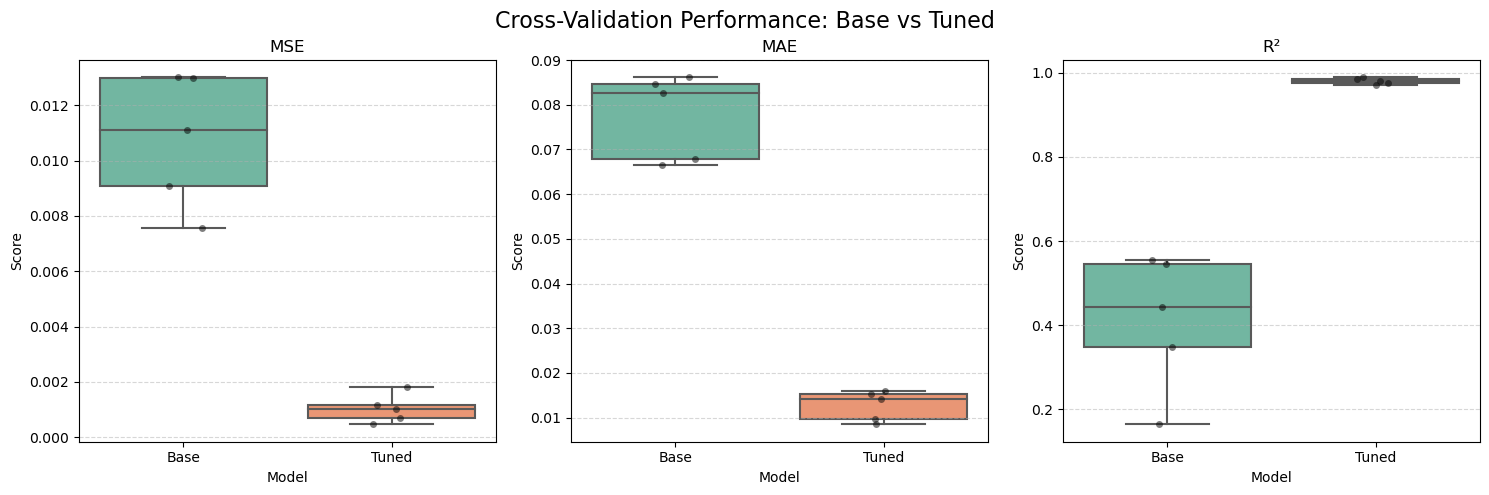

In [12]:
trainer.compare_base_vs_tuned_cv()